# Lunar Lander Deep Q Network Implementation

Lunar Lander Gym Documentation:
https://www.gymlibrary.dev/environments/box2d/lunar_lander/
<br>

**Action Space** <br>
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space** <br>
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

## Test Environment

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

**Produce Reproducible Results**

In [2]:
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set Gym Environment pseudo-random generator at a fixed value
import gym
env = gym.make("LunarLander-v2")
env.seed(seed_value)

# 5. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 6. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
states = env.observation_space.shape[0]
actions = env.action_space.n

In [4]:
print('States: ', states)
print('Actions: ', actions)

States:  8
Actions:  4


In [5]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward

        if done:
            break
    
    print(f'Episode: {episode}, Score: {score}')

env.close()

Episode: 1, Score: -87.16814999350032
Episode: 2, Score: -378.8567352935014
Episode: 3, Score: -419.2673519364487
Episode: 4, Score: -347.6871207195777
Episode: 5, Score: -338.6859157133318


## Create Deep Learning Model

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

In [13]:
def build_dl(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape = (1, states)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [14]:
model = build_dl(states, actions)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________


## Build Agent Using Keras-RL

In [16]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [17]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    buffer = SequentialMemory(limit=250000, window_length=1)
    dqn = DQNAgent(model=model, memory=buffer, policy=policy, 
                    nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [18]:
dqn = build_agent(model, actions)
dqn.compile(optimizer=Adam(), metrics=['mae'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train RL Model

In [19]:
env = gym.make("LunarLander-v2")

In [20]:
dqn.fit(env, nb_steps=500000, visualize=False, verbose=1)

Training for 500000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 43s 4ms/step - reward: -0.2815
40 episodes - episode_reward: -73.660 [-307.995, 107.083] - loss: 10.118 - mae: 18.027 - mean_q: 7.834

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 44s 4ms/step - reward: 0.0602
12 episodes - episode_reward: 48.925 [-226.535, 213.480] - loss: 7.031 - mae: 24.112 - mean_q: 29.211

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 45s 4ms/step - reward: 0.1007
12 episodes - episode_reward: 88.402 [-126.621, 189.947] - loss: 6.250 - mae: 33.414 - mean_q: 44.271

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 45s 5ms/step - reward: 0.0920
11 episodes - episode_reward: 78.154 [-32.389, 126.036] - loss: 5.763 - mae: 36.650 - mean_q: 49.139

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 47s 5ms/step - reward: 0.1059
1

300 000 steps performed

## Evaluate RL Model

In [21]:
import matplotlib.pyplot as plt

In [22]:
episodes = 50
scores = dqn.test(env, nb_episodes=episodes, visualize=False)

Testing for 50 episodes ...
Episode 1: reward: 109.329, steps: 1000
Episode 2: reward: 195.146, steps: 1000
Episode 3: reward: 123.547, steps: 1000
Episode 4: reward: 287.315, steps: 313
Episode 5: reward: 270.427, steps: 178
Episode 6: reward: 292.497, steps: 209
Episode 7: reward: 272.134, steps: 354
Episode 8: reward: 258.525, steps: 187
Episode 9: reward: 280.012, steps: 236
Episode 10: reward: 235.627, steps: 177
Episode 11: reward: 296.210, steps: 210
Episode 12: reward: 262.756, steps: 247
Episode 13: reward: 301.189, steps: 210
Episode 14: reward: 282.006, steps: 177
Episode 15: reward: 276.226, steps: 210
Episode 16: reward: 253.027, steps: 204
Episode 17: reward: 294.160, steps: 189
Episode 18: reward: 302.491, steps: 211
Episode 19: reward: 274.874, steps: 261
Episode 20: reward: 257.099, steps: 234
Episode 21: reward: 244.472, steps: 188
Episode 22: reward: 268.719, steps: 173
Episode 23: reward: 267.087, steps: 219
Episode 24: reward: 258.557, steps: 195
Episode 25: reward

In [23]:
rewards = scores.history['episode_reward']
win = 0

for reward in rewards:
    if reward > 0:
        win += 1

print(f'Average Reward Per Episode: ', round(np.mean(rewards), 2))
print(f"Success Rate: {win/episodes*100} %")

Average Reward Per Episode:  249.94
Success Rate: 98.0 %


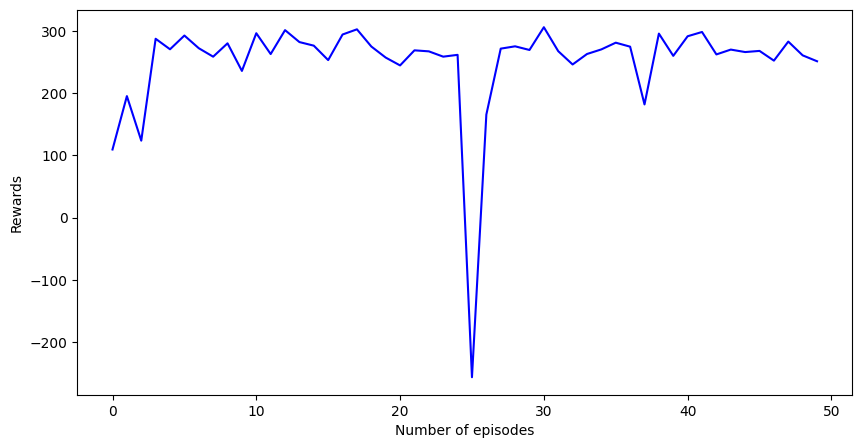

In [24]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(len(rewards)), rewards, color='blue')
plt.xlabel('Number of episodes')
plt.ylabel('Rewards')

plt.show()

In [25]:
_ = dqn.test(env, nb_episodes=10, visualize=True)
env.close()

Testing for 10 episodes ...
Episode 1: reward: 235.075, steps: 221
Episode 2: reward: 268.230, steps: 200
Episode 3: reward: 264.906, steps: 173
Episode 4: reward: 173.918, steps: 516
Episode 5: reward: 246.948, steps: 409
Episode 6: reward: 269.728, steps: 233
Episode 7: reward: 241.781, steps: 228
Episode 8: reward: 303.574, steps: 166
Episode 9: reward: 245.267, steps: 348
Episode 10: reward: -202.452, steps: 195


In [26]:
dqn.save_weights('Lunar Lander DQN.h5f', overwrite=True)